In [18]:
# 📦 Step 1: Load Required Libraries
import joblib
import pandas as pd
import warnings

In [ ]:
# 📁 Step 2: Load Saved Model and Validation Data (consistent with Notebook 2 save)
model = joblib.load("../models/lgbm_model.joblib")
X_valid = pd.read_parquet("../data/processed/X_valid.parquet")
y_valid = pd.read_csv("../data/processed/y_valid.csv").squeeze()

# ✅ Quick check
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_valid shape: (61503, 92)
y_valid shape: (61503,)


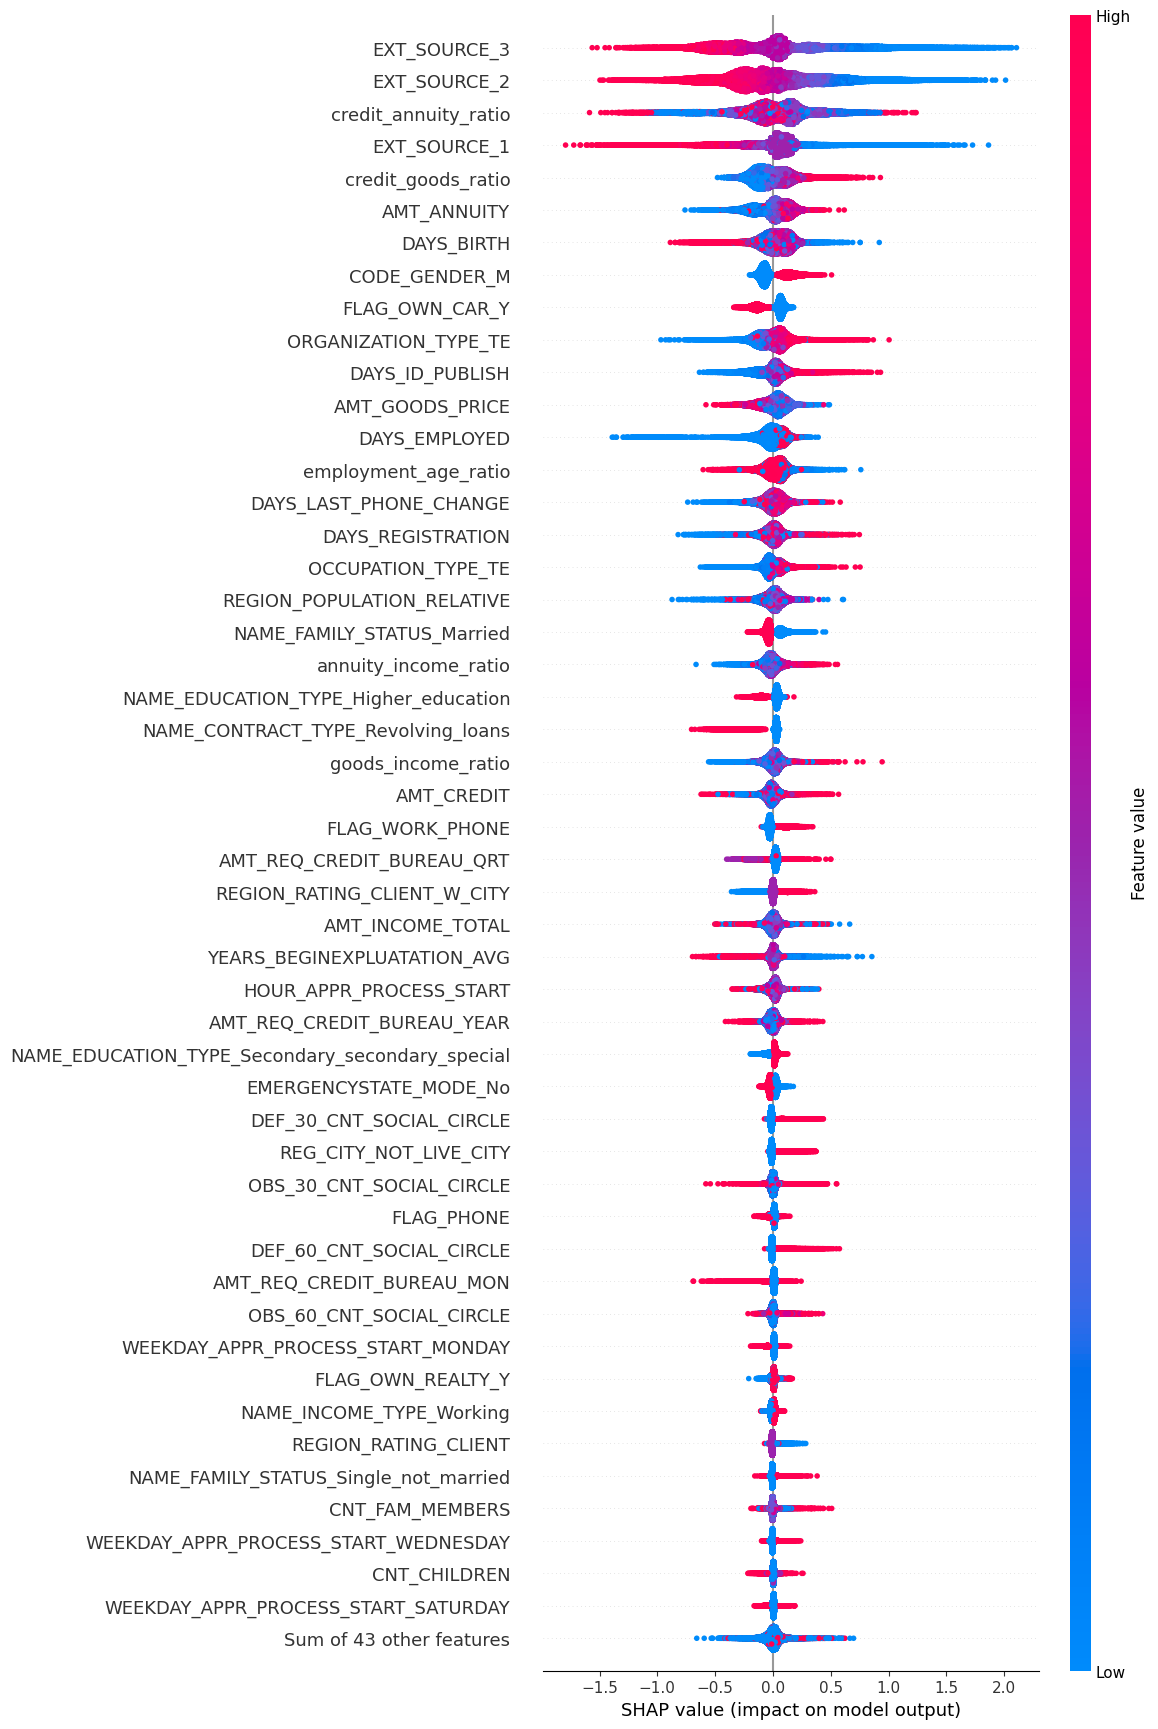

In [12]:
# 🧠 Step 1: Load SHAP and initialize TreeExplainer
import shap
import matplotlib.pyplot as plt

# 2. Initialize SHAP explainer (auto-detects TreeExplainer)
explainer = shap.Explainer(model)

# 3. Compute SHAP values (returns a shap.Explanation object)
shap_values = explainer(X_valid)

# 4. Create beeswarm plot
plt.figure(figsize=(12, 6))
shap.plots.beeswarm(shap_values, max_display=50)

### 🔍 SHAP Global Summary: What Drives Loan Default Risk?

The beeswarm plot below summarizes how the top features affect model predictions. Each dot represents a loan application, with its SHAP value indicating the feature's influence on the model output.

- **Positive SHAP values** (right side): Increase the likelihood of default.
- **Negative SHAP values** (left side): Decrease the likelihood of default.
- **Color**: High feature values are red; low values are blue.

Notable insights:
- External credit scores (EXT_SOURCE_1/2/3) are strong negative predictors — higher values reduce default risk.
- Financial ratios such as `credit_annuity_ratio` and `credit_goods_ratio` contribute meaningfully, validating our feature engineering efforts.
- Some categorical encodings like `ORGANIZATION_TYPE_TE` and `OCCUPATION_TYPE_TE` also show influence.

This view helps build trust in the model by explaining its behavior on aggregate.

In [ ]:
# 📦 Required imports
import shap
import matplotlib.pyplot as plt

# Predict probabilities for class 1 (loan default)
y_pred_proba = model.predict_proba(X_valid)[:, 1]


🔍 Low Risk (Likely to Repay)


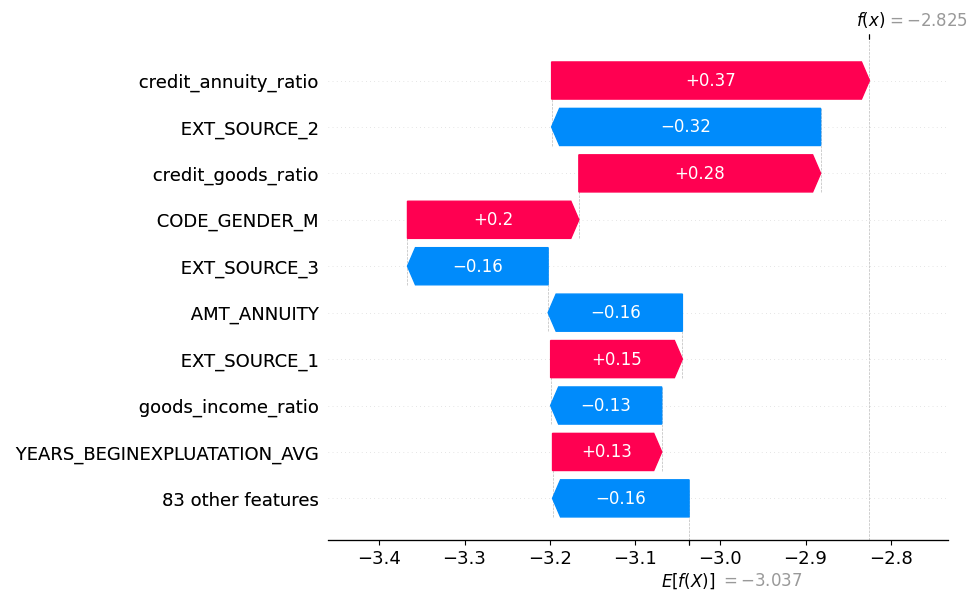


🔍 High Risk (Likely to Default)


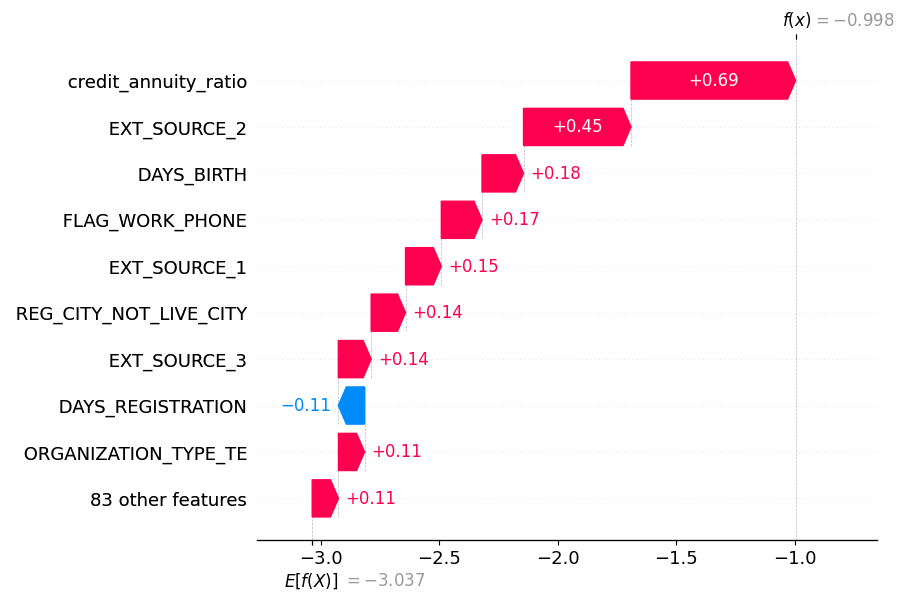


🔍 Borderline Case


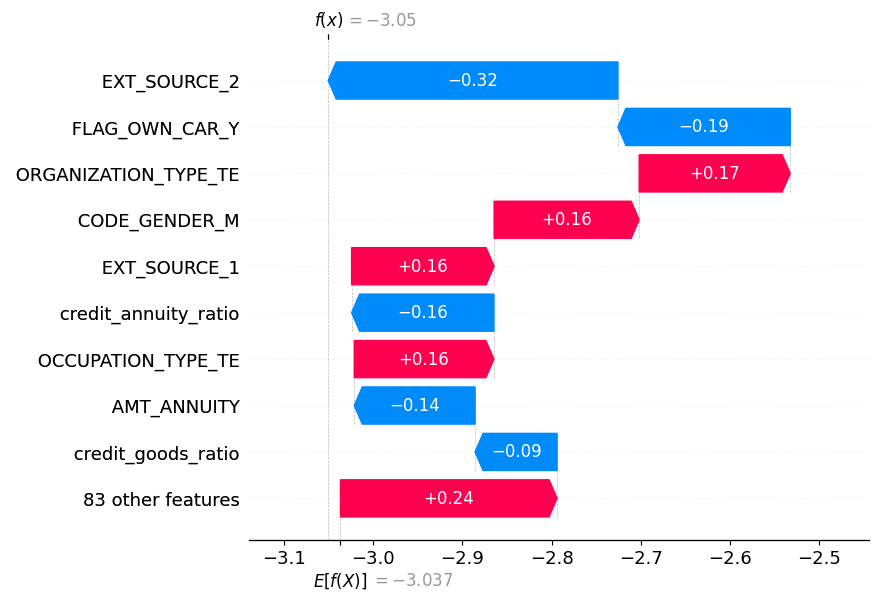

In [19]:
# Suppress specific SHAP warning about output format
warnings.filterwarnings(
    "ignore",
    message="LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray"
)

# 🎯 Select representative applicants
applicants = {
    "Low Risk (Likely to Repay)": X_valid[y_valid == 0].sample(1, random_state=1),
    "High Risk (Likely to Default)": X_valid[y_valid == 1].sample(1, random_state=1),
    "Borderline Case": X_valid.iloc[[y_pred_proba.argsort()[::-1][len(y_valid) // 2]]]
}

# 📊 Generate waterfall plots
for label, applicant in applicants.items():
    shap_values_single = explainer.shap_values(applicant)

    # Handle SHAP output format
    if isinstance(shap_values_single, list):
        shap_val = shap_values_single[1][0]     # SHAP values for class 1
        expected_val = explainer.expected_value[1]
    else:
        shap_val = shap_values_single[0]
        expected_val = explainer.expected_value

    # Plot
    print(f"\n🔍 {label}")
    shap.plots._waterfall.waterfall_legacy(
        shap_values=shap_val,
        expected_value=expected_val,
        features=applicant.iloc[0],
        feature_names=applicant.columns
    )

## 🔍 Local SHAP Explanations: Why These Applicants Were Classified the Way They Were

To complement the global SHAP summary, we analyzed three individual applicants using **SHAP waterfall plots**. These provide a clear, feature-by-feature breakdown of how the model arrived at its prediction.

### 📌 What the Waterfall Plot Shows

- **Blue bars** pull the prediction score **down** toward non-default (safe borrower).
- **Pink bars** push the prediction score **up** toward default (risky borrower).
- The value at the top `f(x)` is the model's output score (in log-odds), and the horizontal path shows how each feature contributes to that score starting from the base value `E[f(x)]`.

---

### 🧑‍💼 Applicant 1: Low-Risk Borrower

- **Key negative contributors (blue):**
  - `EXT_SOURCE_2`, `FLAG_OWN_CAR_Y`, and `credit_annuity_ratio` strongly pulled the risk score down.
- **Smaller positive signals:** `ORGANIZATION_TYPE_TE`, `CODE_GENDER_M`, etc.
- ✅ **Outcome:** The model predicted this applicant is very likely to repay.

---

### ⚖️ Applicant 2: Borderline Case

- **Mixed SHAP values** indicate balanced push and pull:
  - `credit_annuity_ratio` and `EXT_SOURCE_2` pushed risk up.
  - `AMT_ANNUITY`, `goods_income_ratio`, and `EXT_SOURCE_1` pulled it down.
- ❓ **Outcome:** This applicant is near the decision boundary — likely borderline.

---

### 🔺 Applicant 3: High-Risk Borrower

- **Strong positive contributors:**
  - `credit_annuity_ratio` (+0.69), `EXT_SOURCE_2` (+0.45), `DAYS_BIRTH`, etc. pushed the score sharply up.
- Only one small negative contributor: `DAYS_REGISTRATION`.
- ❌ **Outcome:** The model classified this applicant as high risk of default.

---

### 🔍 SHAP Local Explanations Summary (3 Applicant Types)

#### 🟢 1. Low Risk Applicant (Likely to Repay)
- **Prediction:** Low probability of default
- **Top Contributors:**
  - ✅ **High Income** → Positive impact on repayment likelihood  
  - ✅ **Short employment gap** → Indicates financial stability  
  - ✅ **Reasonable credit amount relative to goods price and income**
- **Interpretation:** Model sees strong financial capacity and responsible borrowing behavior.

---

#### 🔴 2. High Risk Applicant (Likely to Default)
- **Prediction:** High probability of default
- **Top Contributors:**
  - ❌ **Low income relative to annuity and credit** → Increases risk  
  - ❌ **Long employment gap (possibly unemployed)**  
  - ❌ **High credit-to-goods ratio** → Suggests overleveraging
- **Interpretation:** Model flags financial vulnerability and repayment burden.

---

#### 🟡 3. Borderline Applicant (Medium Risk)
- **Prediction:** Moderate probability of default (~0.5 threshold)
- **Top Contributors:**
  - ✅ **Decent income and stable employment**  
  - ❌ **Slightly high credit amount and debt-to-income ratio**
- **Interpretation:** A balanced case — the model is uncertain. Could go either way depending on economic or behavioral shifts.